# Проект-ДЗ по Эксплуатации

В данном проекте вы выполните комплексное домашнее задание по подготовке, оптимизации и развертыванию модели машинного обучения с использованием современных инструментов. Цель проекта – освоить процессы обучения, конвертации, оптимизации и интеграции моделей в продакшн-среду с применением Triton Inference Server, Docker и микросервисной архитектуры.

1. **Обучение модели**
   - Обучите самописную модель на базе **Torch** или **TensorFlow**.
   - Используйте стандартные слои, избегая кастомных решений.

In [1]:
import onnx
import onnxruntime as ort
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Загрузка датасета MNIST
train_data = datasets.MNIST(root='../data/train', train=True, download=False, transform=transform)
test_data = datasets.MNIST(root='../data/test', train=False, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [3]:
next(enumerate(train_loader))[1][0].shape

torch.Size([64, 1, 28, 28])

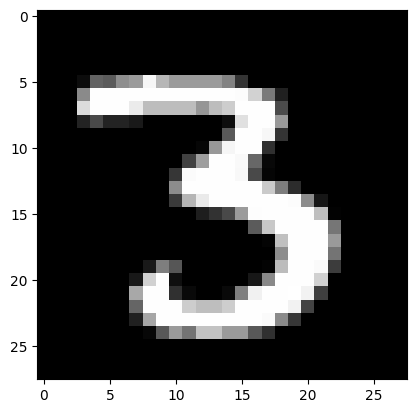

In [4]:
plt.imshow(train_data[12][0][0], cmap=plt.get_cmap('gray'))

In [91]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 0)
        self.conv3 = nn.Conv2d(16, 120, 5, 1, 0)
        self.pool = nn.AvgPool2d(2, 2)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x)) #28 * 28 * 6
        x = self.pool(x) #14 * 14 * 6
        x = torch.tanh(self.conv2(x)) #10 * 10 * 16
        x = self.pool(x) #5 * 5 * 16
        x = torch.tanh(self.conv3(x)) #1 * 1 * 120 = 120
        x = x.view(x.size(0), -1) #120
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

In [92]:
EPOCHS = 5
BATCH_SIZE = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.11)
#optimazer = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()
loss_history = list()

In [93]:
model.train()
for epoch in range(EPOCHS):
    for i, (batch, labels) in enumerate(tqdm(train_loader)):
        loss = torch.tensor(0, dtype=torch.float32)
        optimizer.zero_grad()
        batch = batch.to(device)
        labels = labels.to(device)
        output = model(batch)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        # ===============
        loss_history.append(loss.log().item())
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.81it/s]


Эпоха 1 завершилась с функцией стоимости на последнем пакете = 0.056474097073078156


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.64it/s]


Эпоха 2 завершилась с функцией стоимости на последнем пакете = 0.1177120953798294


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.20it/s]


Эпоха 3 завершилась с функцией стоимости на последнем пакете = 0.002971390960738063


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 52.31it/s]


Эпоха 4 завершилась с функцией стоимости на последнем пакете = 0.024019567295908928


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.36it/s]

Эпоха 5 завершилась с функцией стоимости на последнем пакете = 0.012384621426463127


In [94]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model.eval()

f1_train = 0
acc_train = 0

with torch.no_grad():
    for i, (batch, labels) in enumerate(tqdm(train_loader)):

        batch = batch.to(device)
        labels = labels.to(device)
        output = model(batch)

        outputs = torch.argmax(output, dim=1)
        f1_train += f1_score(labels.cpu(), outputs.cpu(), average='macro')
        acc_train += accuracy_score(labels.cpu(), outputs.cpu())

print(f1_train / len(train_loader))
print(acc_train / len(train_loader))

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 55.59it/s]

0.9879716318717301
0.9894722814498934


In [ ]:
# работает
# m = torch.jit.script(model)
# m.save("./hw_model_mnist/torch_usual/1/model.pt")

2. **Конвертация в ONNX**
   - Экспортируйте обученную модель в формат **ONNX**.

In [95]:
# Путь для сохранения модели
onnx_model_path = "./hw_model_mnist/onnx/1/model.onnx"

# Определяем динамический размер батча
dynamic_axes = {
    'input': {0: 'batch_size'},  # 0-ая ось входных данных - размер батча
    'output': {0: 'batch_size'}  # 0-ая ось выходных данных - размер батча
}

example_input = next(enumerate(train_loader))[1][0].to(device)

torch.onnx.export(model,      # модель PyTorch
                  example_input,       # пример входных данных
                  onnx_model_path,     # путь для сохранения ONNX модели
                  export_params=True,  # экспортировать обученные параметры
                  opset_version=13,    # версия ONNX операторов (13 рекомендуется)
                  do_constant_folding=True,  # оптимизация: константное сворачивание
                  input_names=['input'],   # имя входного тензора
                  output_names=['output'], # имя выходного тензора
                  dynamic_axes=dynamic_axes) # динамические оси

In [96]:
# Сравнение результатов предсказаний
# Создаем сессию для исходной модели
ort_session = ort.InferenceSession(onnx_model_path)
# ort.get_device()

input_name = ort_session.get_inputs()[0].name
input_shape = ort_session.get_inputs()[0].shape

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

f1_train = []
acc_train = []

for i, (batch, labels) in enumerate(tqdm(train_loader)):

    batch = batch.to(device)
    labels = labels.to(device)
    output = ort_session.run(["output"], {input_name: batch.cpu().numpy()})

    outputs = torch.tensor(output[0])
    f1_train.append(f1_score(labels.cpu(), outputs.argmax(dim=1).cpu(), average='macro'))
    acc_train.append(accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu()))

print(f"F1 Score: {np.mean(f1_train)}")
print(f"Accuracy: {np.mean(acc_train)}")

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:33<00:00, 27.68it/s]

F1 Score: 0.9880971559498952
Accuracy: 0.9894722814498934


3. **(Опционально) Конвертация в TensorRT (TRT)**
   - При необходимости, конвертируйте модель в формат **TensorRT** для повышения производительности инференса.

In [ ]:
# Внутри контейнера
# dpkg -l | grep TensorRT

In [97]:
import os
import tensorrt as trt

# Инициализируем логгер TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
# fp16_plan_path = "./hw_model_mnist/trt_fp_16/1/model.plan"
fp16_plan_path = "./wrong_model.plan"

def build_engine(onnx_file_path, fp16_mode=True, workspace_size=1 << 30):
    """
    Функция для сборки сериализованного TensorRT engine из ONNX-файла.

    Параметры:
      onnx_file_path - путь к ONNX-файлу.
      fp16_mode    - если True, собирается engine с поддержкой FP16.
      workspace_size - максимальный объём рабочего пространства (в байтах).

    Возвращает:
      Сериализованный engine (в виде bytes) или None при ошибке.
    """
    # Используем флаг EXPLICIT_BATCH (новый API TensorRT 10+)
    explicit_batch = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    with trt.Builder(TRT_LOGGER) as builder, \
         builder.create_network(explicit_batch) as network, \
         trt.OnnxParser(network, TRT_LOGGER) as parser:

        # Создаем конфигурацию сборки и задаем размер рабочего пространства
        config = builder.create_builder_config()
        config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, workspace_size)

        # Устанавливаем флаг FP16, если требуется
        if fp16_mode:
            config.set_flag(trt.BuilderFlag.FP16)
            print("Сборка в режиме FP16")
        else:
            print("Сборка в режиме FP32")

        # Загружаем и парсим ONNX-файл
        print(f"Загружаем ONNX-файл: {onnx_file_path}")
        try:
            with open(onnx_file_path, 'rb') as model_file:
                onnx_data = model_file.read()
        except Exception as e:
            print(f"Ошибка чтения ONNX-файла: {e}")
            return None

        if not parser.parse(onnx_data):
            print("Ошибка при парсинге ONNX-файла:")
            for error_idx in range(parser.num_errors):
                print(parser.get_error(error_idx))
            return None
        print("ONNX-файл успешно спарсен.")
        
        # Получаем входной тензор и проверяем его размеры
        input_tensor = network.get_input(0)
        print("Размер входного тензора:", input_tensor.shape)
        
        # Если вход содержит динамические размеры (например, -1), создаём оптимизационный профиль.
        if any(dim == -1 for dim in input_tensor.shape):
            profile = builder.create_optimization_profile()
            # Здесь задаем минимальные, оптимальные и максимальные размеры для входа.
            # В данном примере предполагается, что вход имеет форму [batch_size, 10],
            # и мы фиксируем batch_size равным 1. При необходимости измените размеры.
            profile.set_shape(input_tensor.name, (1, 1, 28, 28), (4, 1, 28, 28), (8, 1, 28, 28))
            config.add_optimization_profile(profile)
            print("Оптимизационный профиль установлен для динамического входа.")

        # Сборка сериализованного engine с использованием нового API (build_serialized_network)
        serialized_engine = builder.build_serialized_network(network, config)
        if serialized_engine is None:
            print("Не удалось собрать engine!")
        return serialized_engine

In [98]:
# Путь к ONNX-файлу (например, экспортированной модели PyTorch)
onnx_file_path = "./hw_model_mnist/onnx/1/model.onnx"

# Сборка и сериализация FP16-движка
print("\nСборка FP16-движка...")
engine_fp16 = build_engine(onnx_file_path, fp16_mode=False)
if engine_fp16 is None:
    raise RuntimeError("Сборка FP16-движка завершилась неудачно!")
with open(fp16_plan_path, "wb") as f:
    f.write(engine_fp16)
print(f"FP16-движок сохранён: {fp16_plan_path}")

# Вывод размеров созданных файлов
size_fp16 = os.path.getsize(fp16_plan_path)
print("\nРазмеры сериализованных движков:")
print(f"FP16: {size_fp16} байт ({size_fp16 / (1024 * 1024):.2f} MB)")


Сборка FP16-движка...
Сборка в режиме FP32
Загружаем ONNX-файл: ./hw_model_mnist/onnx/1/model.onnx
ONNX-файл успешно спарсен.
Размер входного тензора: (-1, 1, 28, 28)
Оптимизационный профиль установлен для динамического входа.
FP16-движок сохранён: ./wrong_model.plan

Размеры сериализованных движков:
FP16: 2731668 байт (2.61 MB)


In [99]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import time
import os

# --- Настройки ---
# Укажите правильный путь к вашему .plan файлу
engine_path = "./wrong_model.plan"
if not os.path.exists(engine_path):
    print(f"Ошибка: Файл движка не найден по пути: '{engine_path}'")
    print("Пожалуйста, убедитесь, что путь указан верно.")
    # Создадим фиктивный файл для предотвращения падения при импорте,
    # но работать это не будет. Замените на ваш реальный .plan
    try:
        with open(engine_path, "w") as f:
            f.write("dummy")
        print(f"Создан фиктивный файл: {engine_path}. ЗАМЕНИТЕ ЕГО НА ВАШ ДВИЖОК!")
    except:
        pass
    # exit() # Лучше выйти, если файла нет

# Глобальный логгер TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# --- Класс для хранения буферов ---
class HostDeviceMem:
    def __init__(self, host_mem, device_mem, name, shape, dtype):
        self.host = host_mem
        self.device = device_mem
        self.name = name
        self.shape = shape
        self.dtype = dtype
        self.nbytes = host_mem.nbytes if host_mem is not None else 0

    def __str__(self):
        return f"HostDeviceMem(Name: {self.name}, Shape: {self.shape}, Dtype: {self.dtype})"

    def __repr__(self):
        return self.__str__()

# --- Функции ---
def load_engine(engine_path):
    """Загружает сериализованный движок TensorRT."""
    print(f"Загрузка движка из: {engine_path}")
    try:
        with open(engine_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
            engine = runtime.deserialize_cuda_engine(f.read())
        if engine is None:
            raise RuntimeError("Не удалось десериализовать движок.")
        print("Движок успешно загружен.")
        return engine
    except FileNotFoundError:
        print(f"Ошибка: Файл движка не найден: {engine_path}")
        raise
    except Exception as e:
        print(f"Ошибка при загрузке движка: {e}")
        raise

def allocate_buffers_v3(engine, context, input_data_map):
    """
    Выделяет буферы на хосте и устройстве для входов и выходов.
    Для выходов размеры определяются динамически через контекст.

    Args:
        engine: Загруженный ICudaEngine.
        context: Созданный IExecutionContext.
        input_data_map (dict): Словарь: {имя_входного_тензора: np.array_с_данными}.

    Returns:
        inputs (list): Список HostDeviceMem для входных данных.
        outputs (list): Список HostDeviceMem для выходных данных.
        stream: CUDA-поток.
    """
    inputs_alloc = []
    outputs_alloc = []
    bindings_map = {} # Карта {имя_тензора: адрес_на_устройстве}
    stream = cuda.Stream()

    print("\n--- Выделение буферов (v3) ---")
    # 1. Обработка входов и установка их формы в контексте
    for i in range(engine.num_io_tensors):
        name = engine.get_tensor_name(i)
        if engine.get_tensor_mode(name) == trt.TensorIOMode.INPUT:
            if name not in input_data_map:
                raise ValueError(f"Входной тензор '{name}' не найден в input_data_map.")

            host_data = input_data_map[name]
            actual_shape = host_data.shape
            dtype = trt.nptype(engine.get_tensor_dtype(name))
            engine_shape = engine.get_tensor_shape(name)

            print(f"Вход: '{name}', Форма из движка: {engine_shape}, "
                  f"Факт. форма: {actual_shape}, Тип: {dtype}")

            if host_data.dtype != dtype:
                print(f"Предупреждение: Тип данных входа '{name}' ({host_data.dtype}) "
                      f"не совпадает с ожидаемым ({dtype}). Преобразование...")
                host_data = host_data.astype(dtype)
                input_data_map[name] = host_data # Обновляем для консистентности

            # Устанавливаем актуальную форму входа в контексте
            try:
                context.set_input_shape(name, actual_shape)
            except Exception as e:
                raise ValueError(f"Не удалось установить форму {actual_shape} для входа '{name}'. "
                                 f"Убедитесь, что форма совместима с профилем движка. Ошибка: {e}")
            # Выделяем память
            host_mem = cuda.pagelocked_empty(host_data.nbytes // 4, dtype=host_data.dtype)
            np.copyto(host_mem, host_data.ravel()) # Копируем данные сразу
            device_mem = cuda.mem_alloc(host_mem.nbytes)

            hdm = HostDeviceMem(host_mem, device_mem, name, actual_shape, host_data.dtype)
            inputs_alloc.append(hdm)
            bindings_map[name] = int(device_mem)
            print(f"  Выделен вход '{name}': Форма={actual_shape}, Байт={host_mem.nbytes}")

    if not bindings_map:
        raise ValueError("Не найдено входных тензоров в движке.")

    # 2. Получение форм выходов из контекста и выделение памяти
    for i in range(engine.num_io_tensors):
        name = engine.get_tensor_name(i)
        if engine.get_tensor_mode(name) == trt.TensorIOMode.OUTPUT:
            dtype = trt.nptype(engine.get_tensor_dtype(name))
            # Получаем форму выхода из КОНТЕКСТА (после установки форм входов)
            try:
                output_shape_tuple = tuple(context.get_tensor_shape(name))
            except Exception as e:
                raise RuntimeError(f"Не удалось получить форму для выхода '{name}' из контекста. "
                                   f"Ошибка: {e}")

            print(f"Выход: '{name}', Форма из контекста: {output_shape_tuple}, Тип: {dtype}")

            if -1 in output_shape_tuple:
                raise ValueError(f"Ошибка: Форма выхода '{name}' {output_shape_tuple} "
                                 "все еще содержит динамические измерения. "
                                 "Убедитесь, что все входные формы были установлены и "
                                 "движок может определить все выходные формы.")

            try:
                # Объем может быть 0, если измерение 0
                num_elements = trt.volume(output_shape_tuple) if -1 not in output_shape_tuple else 0
                if num_elements < 0: # Может случиться, если форма из движка была (-1,)
                    raise ValueError(f"Некорректный объем для {name}: {output_shape_tuple}")
                nbytes = num_elements * np.dtype(dtype).itemsize
            except Exception as e:
                raise ValueError(f"Не удалось рассчитать объем для выхода '{name}' "
                                 f"с формой {output_shape_tuple}: {e}")

            host_mem = cuda.pagelocked_empty(num_elements, dtype=dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)

            hdm = HostDeviceMem(host_mem, device_mem, name, output_shape_tuple, dtype)
            outputs_alloc.append(hdm)
            bindings_map[name] = int(device_mem)
            print(f"  Выделен выход '{name}': Форма={output_shape_tuple}, Байт={host_mem.nbytes}")

    print("--- Выделение буферов завершено ---")
    return inputs_alloc, outputs_alloc, bindings_map, stream

def do_inference_v3(context, inputs_alloc, outputs_alloc, bindings_map, stream):
    """
    Выполняет инференс с использованием enqueue_v3.

    Args:
        context: IExecutionContext.
        inputs_alloc (list): Список HostDeviceMem для входов.
        outputs_alloc (list): Список HostDeviceMem для выходов.
        bindings_map (dict): {имя_тензора: адрес_на_устройстве}.
        stream: CUDA-поток.

    Returns:
        dict: Словарь {имя_выходного_тензора: np.array_с_результатом}.
    """
    # 1. Установка адресов буферов в контексте
    for name, addr in bindings_map.items():
        try:
            context.set_tensor_address(name, addr)
        except Exception as e:
            print(f"Ошибка при установке адреса для тензора '{name}': {e}. "
                  "Убедитесь, что имя тензора верное.")
            raise

    # 2. Копирование входных данных на устройство (асинхронно)
    for inp in inputs_alloc:
        cuda.memcpy_htod_async(inp.device, inp.host, stream)
    # 3. Запуск инференса (асинхронно)
    if not context.execute_async_v3(stream_handle=stream.handle):
        raise RuntimeError("Выполнение context.enqueue_v3() не удалось.")
    # 4. Копирование выходных данных с устройства (асинхронно)
    for out in outputs_alloc:
        cuda.memcpy_dtoh_async(out.host, out.device, stream)

    # 5. Синхронизация потока
    stream.synchronize()

    # 6. Формирование результата
    results = {}
    for out in outputs_alloc:
        results[out.name] = out.host.reshape(out.shape)
    print(results)
    return results

def get_engine_io_details(engine):
    """Извлекает информацию о входах и выходах движка."""
    input_details = []
    output_details = []
    print("\n--- Информация о тензорах движка ---")
    for i in range(engine.num_io_tensors):
        name = engine.get_tensor_name(i)
        is_input = engine.get_tensor_mode(name) == trt.TensorIOMode.INPUT
        dtype = trt.nptype(engine.get_tensor_dtype(name))
        shape = tuple(engine.get_tensor_shape(name)) # Форма из движка (может быть с -1)
        detail = {"name": name, "shape_engine": shape, "dtype": dtype}
        if is_input:
            input_details.append(detail)
            print(f"Вход: '{name}', Форма: {shape}, Тип: {dtype}")
        else:
            output_details.append(detail)
            print(f"Выход: '{name}', Форма: {shape}, Тип: {dtype}")
    print("-" * 30)
    return input_details, output_details

# --- Основной блок ---
if __name__ == "__main__":
    try:
        # 1. Загрузка движка
        engine = load_engine(engine_path)

        # 2. Получение информации о входах/выходах
        input_details, output_details = get_engine_io_details(engine)

        if not input_details:
            print("Ошибка: Не найдены входные тензоры в движке.")
            exit()
        if not output_details:
            print("Ошибка: Не найдены выходные тензоры в движке.")
            exit()

        # 3. Создание контекста выполнения
        context = engine.create_execution_context()
        if not context:
            raise RuntimeError("Не удалось создать контекст выполнения.")

        # 4. Подготовка входных данных
        input_data_map = {}
        print("\n--- Подготовка входных данных ---")
        for detail in input_details:
            input_name = detail["name"]
            input_dtype = detail["dtype"]
            # Берем форму из движка, заменяя -1 на конкретные значения
            # ВАЖНО: Вы должны знать, какие измерения динамические
            # Например, если shape_engine это (-1, 1, 28, 28), -1 - это батч
            batch_size = 1 # Пример: Задаем батч
            actual_shape_list = list(detail["shape_engine"])

            # Ищем динамические измерения (-1) и заменяем их
            # Это очень упрощенный пример. Для сложных случаев может
            # потребоваться более умная логика или знание о модели.
            # Здесь предполагаем, что первое измерение - батч.
            dynamic_dims = [i for i, dim in enumerate(actual_shape_list) if dim == -1]
            if dynamic_dims:
                if dynamic_dims == [0]: # Если только первое измерение динамическое (батч)
                    actual_shape_list[0] = batch_size
                    print(f"Для входа '{input_name}': динамическое измерение (батч) "
                          f"заменено на {batch_size}")
                else:
                    # Если другие измерения динамические, вам нужно их определить
                    # Например, для NLP это может быть длина последовательности
                    # Установим для примера, но это нужно адаптировать
                    for dim_idx in dynamic_dims:
                        if dim_idx == 0 : actual_shape_list[dim_idx] = batch_size
                        else:
                            guessed_dim = 32
                            actual_shape_list[dim_idx] = guessed_dim
                            print(f"Предупреждение: Для входа '{input_name}' динамическое "
                                  f"измерение {dim_idx} заменено на {guessed_dim} (предположение!)")

            actual_shape_tuple = tuple(actual_shape_list)
            print(f"Генерация данных для '{input_name}' формы {actual_shape_tuple}, тип {input_dtype}")
            input_data = np.random.random(actual_shape_tuple).astype(input_dtype)
            input_data_map[input_name] = input_data

        # 5. Выделение буферов
        inputs_alloc, outputs_alloc, bindings_map, stream = allocate_buffers_v3(
            engine, context, input_data_map
        )

        # 6. Выполнение инференса
        print("\n--- Выполнение инференса ---")
        start_time = time.time()
        results = do_inference_v3(context, inputs_alloc, outputs_alloc, bindings_map, stream)
        end_time = time.time()
        print(f"Инференс завершен за {end_time - start_time:.4f} сек.")

        # 7. Вывод результатов
        print("\n--- Результаты инференса ---")
        for name, data in results.items():
            print(f"Выходной тензор '{name}':")
            print(f"  Форма: {data.shape}")
            print(f"  Тип: {data.dtype}")
            print(f"  Несколько первых элементов: {data.flatten()[:5]}...")

    except FileNotFoundError:
        print("Выполнение прервано из-за отсутствия файла движка.")
    except Exception as e:
        print(f"\n--- Произошла ошибка ---")
        import traceback
        traceback.print_exc()

    finally:
        # 8. Очистка (необязательно с pycuda.autoinit, но хорошая практика)
        print("\n--- Очистка ---")
        if 'stream' in locals() and stream:
            del stream
        if 'outputs_alloc' in locals():
            for out in outputs_alloc:
                if out.device:
                    try: out.device.free()
                    except: pass
        if 'inputs_alloc' in locals():
            for inp in inputs_alloc:
                if inp.device:
                    try: inp.device.free()
                    except: pass
        if 'context' in locals():
            del context
        if 'engine' in locals():
            del engine
        print("Очистка завершена.")

Загрузка движка из: ./wrong_model.plan
Движок успешно загружен.

--- Информация о тензорах движка ---
Вход: 'input', Форма: (-1, 1, 28, 28), Тип: <class 'numpy.float32'>
Выход: 'output', Форма: (-1, 10), Тип: <class 'numpy.float32'>
------------------------------

--- Подготовка входных данных ---
Для входа 'input': динамическое измерение (батч) заменено на 1
Генерация данных для 'input' формы (1, 1, 28, 28), тип <class 'numpy.float32'>

--- Выделение буферов (v3) ---
Вход: 'input', Форма из движка: (-1, 1, 28, 28), Факт. форма: (1, 1, 28, 28), Тип: <class 'numpy.float32'>
  Выделен вход 'input': Форма=(1, 1, 28, 28), Байт=3136
Выход: 'output', Форма из контекста: (1, 10), Тип: <class 'numpy.float32'>
  Выделен выход 'output': Форма=(1, 10), Байт=40
--- Выделение буферов завершено ---

--- Выполнение инференса ---
{'output': array([[ 6.0604587 , -5.753708  ,  1.2418654 , -2.8975654 , -0.64198923,
        -2.0862842 ,  5.3396554 , -7.027978  ,  8.567565  ,  0.10630088]],
      dtype=flo

4. **Оптимизация модели средствами Torch/TensorFlow**
   - Примените встроенные методы оптимизации (например, quantization или pruning) для улучшения эффективности модели.

In [100]:
import torch
import torch.nn as nn
import torch.quantization

model.eval()

# Применяем динамическую квантизацию
quantized_model = torch.quantization.quantize_dynamic(
    model, 
    {nn.Conv2d, nn.Linear},  # Список слоев для квантизации
    dtype=torch.qint8  # Используем int8 для весов
)

print(quantized_model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear1): DynamicQuantizedLinear(in_features=120, out_features=84, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear2): DynamicQuantizedLinear(in_features=84, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [101]:
# torch.onnx.export(quantized_model,      # модель PyTorch
#                   example_input,       # пример входных данных
#                   "./hw_model_mnist/torch_quant/1/model.onnx",     # путь для сохранения ONNX модели
#                   export_params=True,  # экспортировать обученные параметры
#                   opset_version=13,    # версия ONNX операторов (13 рекомендуется)
#                   do_constant_folding=True,  # оптимизация: константное сворачивание
#                   input_names=['input'],   # имя входного тензора
#                   output_names=['output'], # имя выходного тензора
#                   dynamic_axes=dynamic_axes) # динамические оси

NotImplementedError: Could not run 'quantized::linear_dynamic' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_dynamic' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\quantized\cpu\qlinear_dynamic.cpp:1027 [kernel]
Meta: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\MetaFallbackKernel.cpp:23 [backend fallback]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:95 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:108 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMAIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:99 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:322 [backend fallback]
AutocastMTIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:466 [backend fallback]
AutocastMAIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:504 [backend fallback]
AutocastXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:542 [backend fallback]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:208 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:198 [backend fallback]


In [ ]:
# torch.save(quantized_model.state_dict(), "./hw_model_mnist/torch_quant/1/model.pt")

5. **Оптимизация модели инструментами ONNX и (опционально) TRT**
   - Используйте оптимизирующие инструменты для ONNX (например, ONNX Runtime) для повышения производительности.
   - (Опционально) Оптимизируйте модель в формате TensorRT.

In [102]:
from onnxruntime.quantization import quantize_dynamic, QuantType
import os

# Динамическое квантование весов
onnx_file_path = "./hw_model_mnist/onnx/1/model.onnx"
quantized_model_path = "./hw_model_mnist/quant_onnx/1/model.onnx"
quantize_dynamic(onnx_file_path, quantized_model_path, weight_type=QuantType.QUInt8)

In [103]:
# Сравнение размеров файлов
original_size = os.path.getsize(onnx_file_path)
quantized_size = os.path.getsize(quantized_model_path)

print(f"Размер исходной модели: {original_size} байт")
print(f"Размер квантованной модели: {quantized_size} байт")
print(f"Сжатие: {(1 - quantized_size / original_size) * 100:.2f}%")

Размер исходной модели: 249235 байт
Размер квантованной модели: 70659 байт
Сжатие: 71.65%


In [104]:
# Сравнение результатов предсказаний
# Создаем сессию для квантоновой модели
ort_session = ort.InferenceSession(quantized_model_path)

input_name = ort_session.get_inputs()[0].name
input_shape = ort_session.get_inputs()[0].shape

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

f1_train = []
acc_train = []

for i, (batch, labels) in enumerate(tqdm(train_loader)):

    batch = batch.to(device)
    labels = labels.to(device)
    output = ort_session.run(["output"], {input_name: batch.cpu().numpy()})

    outputs = torch.tensor(output[0])
    f1_train.append(f1_score(labels.cpu(), outputs.argmax(dim=1).cpu(), average='macro'))
    acc_train.append(accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu()))

print(f"F1 Score: {np.mean(f1_train)}")
print(f"Accuracy: {np.mean(acc_train)}")

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:44<00:00, 21.14it/s]

F1 Score: 0.9884029724040643
Accuracy: 0.9894722814498934


In [105]:
# --- Калибровка (Calibration) для INT8 ---

class MNISTCalibrator(trt.IInt8Calibrator):
    def __init__(self, training_data, cache_file, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.cache_file = cache_file
        # Преобразуем данные в numpy массив.
        self.data = torch.cat([data[0] for data in training_data]).numpy()
        self.data = np.ascontiguousarray(self.data)  # Убеждаемся, что данные лежат в памяти непрерывно
        self.current_index = 0
        # Выделяем память на GPU для одного батча.
        self.device_input = self.data[0].nbytes * self.batch_size

    def get_batch_size(self):
        return self.batch_size

    def get_batch(self, names):
        if self.current_index + self.batch_size > self.data.shape[0]:
            return None
        current_batch = self.data[self.current_index:self.current_index + self.batch_size].ravel()
        self.current_index += self.batch_size
        return [int(self.device_input)]

    def read_calibration_cache(self):
        # Если есть файл кэша, загружаем его.
        if os.path.exists(self.cache_file):
            with open(self.cache_file, "rb") as f:
                return f.read()

    def write_calibration_cache(self, cache):
        # Сохраняем кэш калибровки в файл.
        with open(self.cache_file, "wb") as f:
            f.write(cache)
    
    def get_algorithm(self):
        return trt.CalibrationAlgoType.ENTROPY_CALIBRATION_2

In [106]:
def build_int8_engine(onnx_file_path, calib, workspace_size=1 << 30):
    """
    Функция для сборки сериализованного TensorRT engine в формате INT8.

    Параметры:
      onnx_file_path - путь к ONNX-файлу.
      calib          - объект калибратора.
      workspace_size - максимальный объём рабочего пространства (в байтах).

    Возвращает:
      Сериализованный engine (в виде bytes) или None при ошибке.
    """
    explicit_batch = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    with trt.Builder(TRT_LOGGER) as builder, \
         builder.create_network(explicit_batch) as network, \
         trt.OnnxParser(network, TRT_LOGGER) as parser:

        config = builder.create_builder_config()
        config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, workspace_size)
        config.set_flag(trt.BuilderFlag.INT8)  # Включаем режим INT8
        config.int8_calibrator = calib # Устанавливаем калибратор
        print("Сборка в режиме INT8")

        # Загружаем и парсим ONNX-файл
        print(f"Загружаем ONNX-файл: {onnx_file_path}")
        try:
            with open(onnx_file_path, 'rb') as model_file:
                onnx_data = model_file.read()
        except Exception as e:
            print(f"Ошибка чтения ONNX-файла: {e}")
            return None

        if not parser.parse(onnx_data):
            print("Ошибка при парсинге ONNX-файла:")
            for error_idx in range(parser.num_errors):
                print(parser.get_error(error_idx))
            return None
        print("ONNX-файл успешно спарсен.")

        input_tensor = network.get_input(0)
        print("Размер входного тензора:", input_tensor.shape)

        if any(dim == -1 for dim in input_tensor.shape):
            profile = builder.create_optimization_profile()
            profile.set_shape(input_tensor.name, (1, 1, 28, 28), (4, 1, 28, 28), (8, 1, 28, 28))
            config.add_optimization_profile(profile)
            print("Оптимизационный профиль установлен для динамического входа.")
        
        # Сборка engine'а с использованием нового API
        serialized_engine = builder.build_serialized_network(network, config)
        if serialized_engine is None:
            print("Не удалось собрать engine!")
        return serialized_engine


# onnx_file_path = "hw_model_mnist.onnx"  #  Сначала нужно экспортировать модель в ONNX
calibration_cache = "./trt_int_8/1/mnist_calibration.cache"

# 2. Создаем калибратор, используя часть тренировочных данных (например, первые 1000 изображений)
calib_data = [test_data[i] for i in range(1000)]
calibrator = MNISTCalibrator(calib_data, cache_file=calibration_cache, batch_size=64)

# 3. Собираем INT8 TensorRT engine
int8_engine = build_int8_engine(onnx_file_path, calibrator)

# 4. Сохраняем сериализованный engine (если он был успешно создан)
if int8_engine:
    with open("./trt_int_8/1/model.plan", "wb") as f:
        f.write(int8_engine)
    print("INT8 engine сохранен в model_int8.plan")

C:\Users\itolo\AppData\Local\Temp\ipykernel_14384\2160314726.py:21: DeprecationWarning: Use Deprecated in TensorRT 10.1. Superseded by explicit quantization. instead.
  config.int8_calibrator = calib # Устанавливаем калибратор


Сборка в режиме INT8
Загружаем ONNX-файл: ./hw_model_mnist/onnx/1/model.onnx
ONNX-файл успешно спарсен.
Размер входного тензора: (-1, 1, 28, 28)
Оптимизационный профиль установлен для динамического входа.
INT8 engine сохранен в model_int8.plan


In [107]:
# Вывод размеров созданных файлов
size_int8 = os.path.getsize("./trt_int_8/1/model.plan")
print("\nРазмеры сериализованных движков:")
print(f"INT8: {size_int8} байт ({size_int8 / (1024 * 1024):.2f} MB)")


Размеры сериализованных движков:
INT8: 806988 байт (0.77 MB)


6. **Разработка микросервиса предобработки данных**
   - Спроектируйте микросервис для предобработки данных, необходимых для работы вашей модели.
   - Реализуйте сервис с использованием **Flask**, **FastAPI** или другого подходящего фреймворка.
   - Оформите микросервис в виде **Docker-контейнера**.

В директории homework находится микросервис, нормализирующий данные и превращающий json с данными в torch tensor.
Для создания образа необходимо исполнить команду docker build -t my_docker_app:latest -f Dockerfile . Затем
docker run -p 5000:5000 my_docker_app
Post запрос по http://127.0.0.1:5000/preprocess Headers Key Content-Type Value application/json В body подаем input.json 
Если надо исправить что-то в коде docker ps -a получаем id docker контейнира, после чего docker stop id docker rm id, и повторить сборку

7. **Развёртывание моделей с помощью Triton Inference Server**
   - Запустите **Triton Inference Server**.
   - Задеплойте следующие версии модели:
     - Оригинальная модель.
     - Оптимизированная модель (на базе Torch/TensorFlow).
     - Модель в формате ONNX.
     - Оптимизированная модель ONNX.
     - (Опционально) Модель в формате TRT.

docker run --gpus=all --rm -p8000:8000 -p8001:8001 -p8002:8002 -v C:\Users\itolo\development\mlops\homework\hw_model_mnist:/models nvcr.io/nvidia/tritonserver:25.01-py3 tritonserver --model-repository=/models

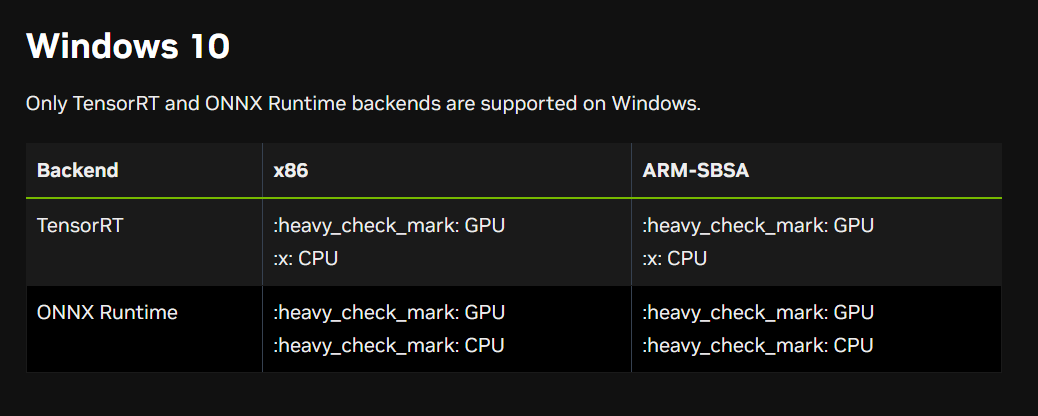

In [ ]:
# ipconfig

8. **Настройка мониторинга метрик**
   - Настройте сбор и визуализацию метрик с помощью **Grafana** и **Prometheus**.
   - Обеспечьте мониторинг как для Triton Inference Server, так и для микросервиса предобработки.

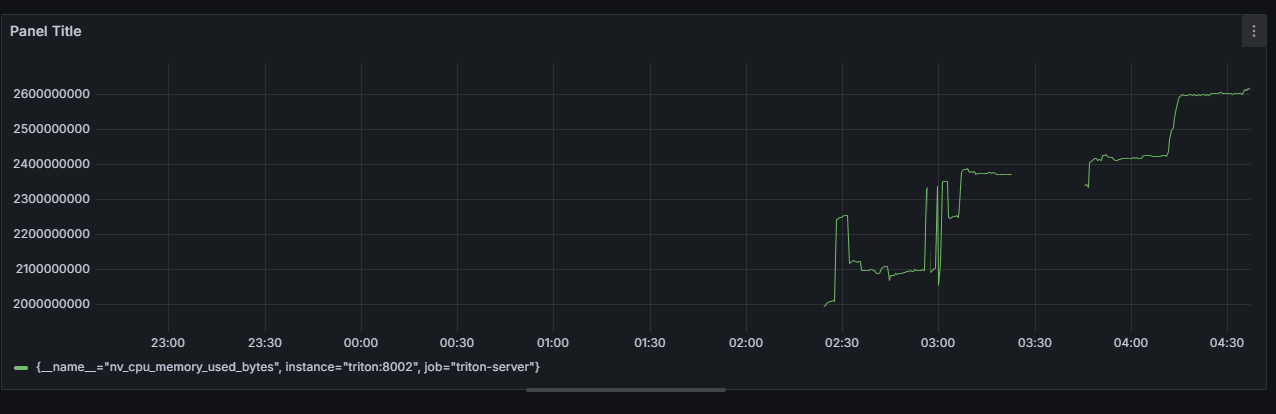

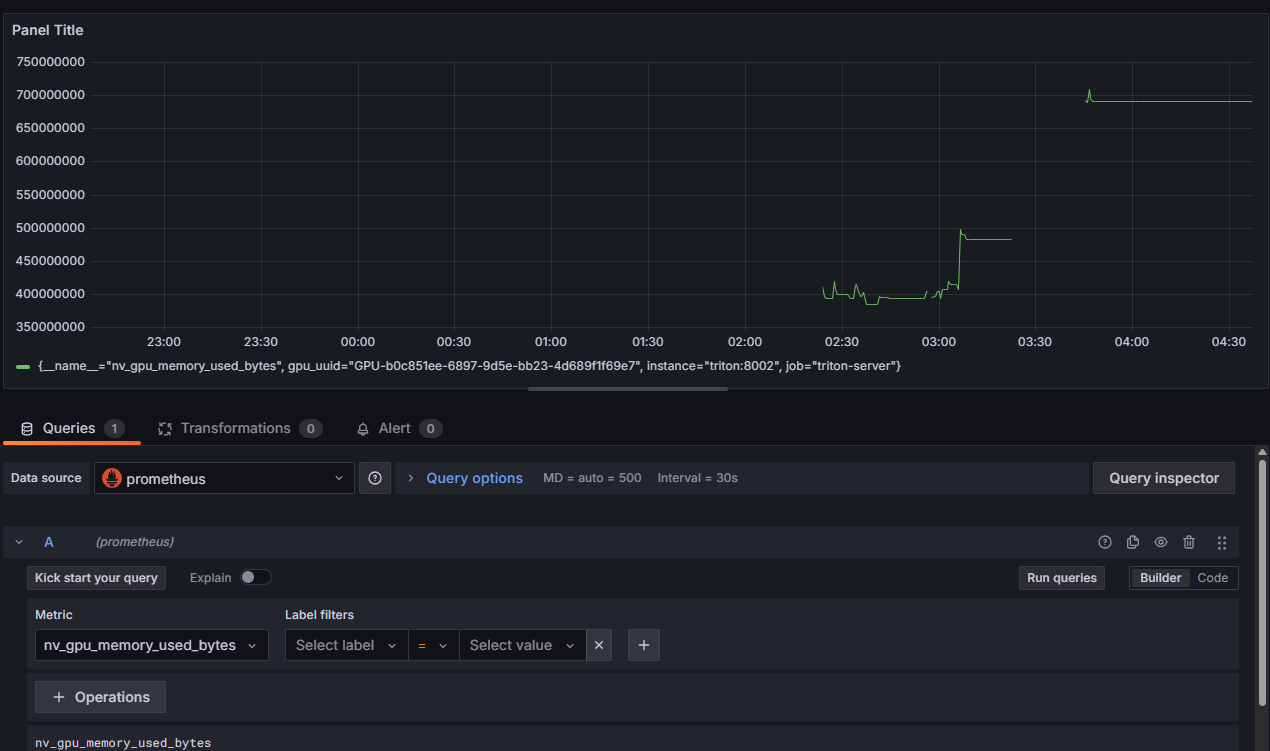

9. **Оркестрация сервисов с помощью docker-compose**
   - Поднимите весь стек сервисов через **docker-compose**, включающий:
     - Микросервис предобработки данных.
     - Triton Inference Server.
     - Систему мониторинга (Prometheus и Grafana).

In [ ]:
docker-compose up

10. **Тестирование и формирование отчёта**
    - Проведите тестирование всех версий модели, отправляя запросы на инференс.
    - Соберите логи работы сервисов.
    - Сформируйте итоговый файл с отчётом, включающим результаты тестирования, собранные логи и анализ производительности.